In [1]:
from networkx.generators.random_graphs import connected_watts_strogatz_graph
from collections import defaultdict, Counter
from random import random, sample
import matplotlib.pyplot as plt
import multiprocessing as mp
from itertools import cycle, chain
import matplotlib as mpl
import networkx as nx
import numpy as np
import time

In [2]:
def mp_map(mapfn, it, thread_count=None):
    if thread_count is None:
        thread_count = mp.cpu_count()
    pool = mp.Pool(thread_count)
    results = pool.map(mapfn, it)
    pool.close()
    return results

def prepend(h, it):
    for i in it:
        yield h, i

def take(li, k):
    return [i[k] for i in li]

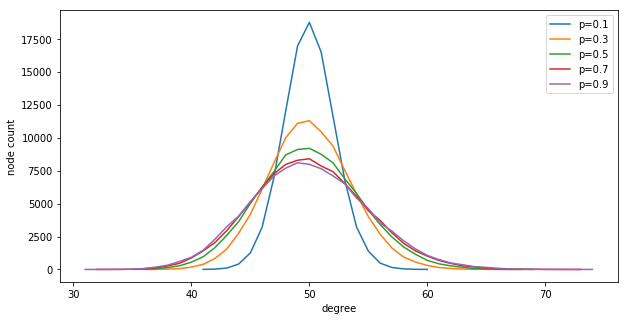

In [7]:
import network_scaling_worker

n=100*1000
k=50

if __name__ ==  '__main__':
    results = mp_map(
        network_scaling_worker.mp_degree_distribution,
        [(n, k, p/100.0) for p in range(10, 110, 20)])

plt.figure(figsize=(10,5))
plt.xlabel('degree')
plt.ylabel('node count')
for x in results:
    plt.plot(x[1], x[2])
plt.legend(['p=%s' % x[0] for x in results])
plt.show()

In [22]:
import network_scaling_worker

ns = [10*1000, 50*1000, 100*1000, 300*1000]
k=50
ps = range(0, 120, 20)
T=50
N=0

results = []
if __name__ ==  '__main__':
    for n in ns:
        print('Running simulations for n=%s...' % n)
        start_time = time.time()
        results.extend(mp_map(
            network_scaling_worker.mp_lifts,
            [(n, k, p/100.0, N, T) for p in ps],
        ))
        elapsed_time = time.time() - start_time
        print('Done! Elapsed %s' % time.strftime("%M:%S", time.gmtime(elapsed_time)))

Running simulations for n=10000...
Done! Elapsed 00:07
Running simulations for n=50000...
Done! Elapsed 00:38
Running simulations for n=100000...
Done! Elapsed 01:28
Running simulations for n=300000...
Done! Elapsed 06:21


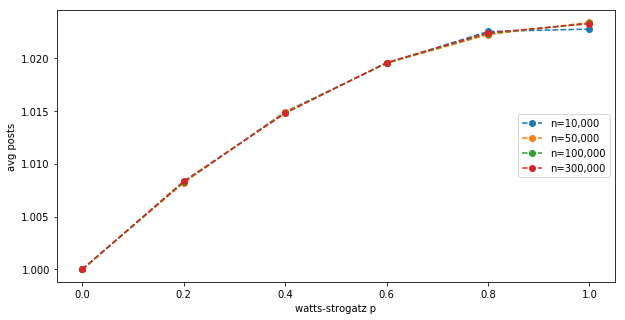

In [23]:
def xs(n): return take(take(filter(lambda x: x[0][0] == n, results), 0), 2)
def ys(n): return take(take(filter(lambda x: x[0][0] == n, results), 1), 3)
plt.figure(figsize=(10,5))
plt.xlabel('watts-strogatz p')
plt.ylabel('avg posts')
plt.plot(xs(10*1000), ys(10*1000), marker='o', linestyle='--')
plt.plot(xs(50*1000), ys(50*1000), marker='o', linestyle='--')
plt.plot(xs(100*1000), ys(100*1000), marker='o', linestyle='--')
plt.plot(xs(300*1000), ys(300*1000), marker='o', linestyle='--')
plt.legend(['n=10,000', 'n=50,000', 'n=100,000', 'n=300,000'], loc='center right')
plt.show()

In [19]:
n=100*1000
k=50
p=0.1
T=50

g = connected_watts_strogatz_graph(n=n, k=k, p=p).to_directed()
posts = prev_posts = None
for t in range(T):
    posts = step_posts(g, prev_posts)
    prev_posts = posts
baseline_avg_posts = np.mean(list(posts.values()))
print("Correct baseline for a (%s, %s, %s) Watts-Strogatz graph after %s steps = %.4f" % (n, k, p, T, baseline_avg_posts))

Correct baseline for a (100000, 50, 0.1) Watts-Strogatz graph after 50 steps = 1.0044


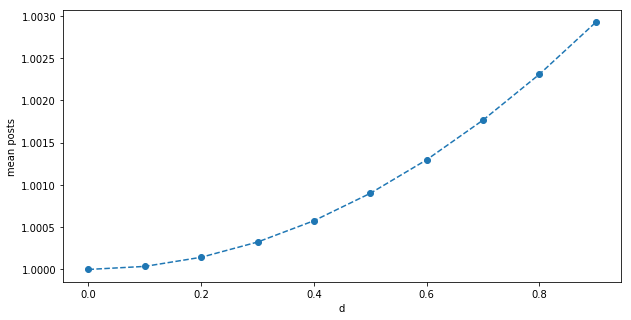

In [32]:
def c(d):
    return (1/2) * ( (1/4) / (1-(50-d)*(3/200)) + (1/4) / (1-(50+d)*(3/200)) )

plt.figure(figsize=(10,5))
plt.xlabel('d')
plt.ylabel('mean posts')
fd = [(d/10.0, c(d/10.0)) for d in range(0, 10)]
plt.plot([x[0] for x in fd], [x[1] for x in fd], marker='o', linestyle='--')
plt.show()

In [3]:
import network_scaling_worker

ns = [10*1000, 50*1000, 100*1000, 300*1000]
k=50
ps = range(0, 120, 20)
num_samples = 1000

results = []
if __name__ ==  '__main__':
    for n in ns:
        print('Running simulations for n=%s...' % n)
        start_time = time.time()
        results.extend(mp_map(
            network_scaling_worker.mp_shortest_paths,
            [(n, k, p/100.0, num_samples) for p in ps],
        ))
        elapsed_time = time.time() - start_time
        print('Done! Elapsed %s' % time.strftime("%M:%S", time.gmtime(elapsed_time)))

Running simulations for n=10000...
Done! Elapsed 00:16
Running simulations for n=50000...
Done! Elapsed 01:17
Running simulations for n=100000...
Done! Elapsed 02:35
Running simulations for n=300000...
Done! Elapsed 08:06


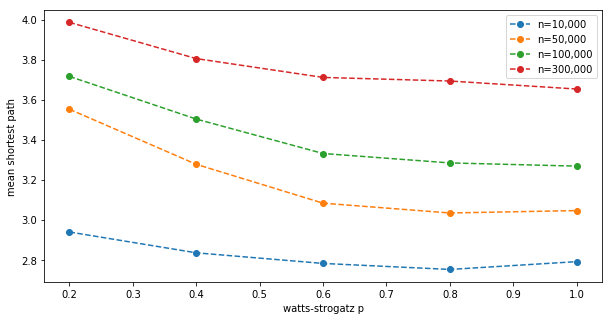

In [7]:
def xs(n): return take(take(filter(lambda x: x[0][0] == n, results), 0), 2)[1:]
def ys(n): return      take(filter(lambda x: x[0][0] == n, results), 1)[1:]
plt.figure(figsize=(10,5))
plt.xlabel('watts-strogatz p')
plt.ylabel('mean shortest path')
plt.plot(xs(10*1000), ys(10*1000), marker='o', linestyle='--')
plt.plot(xs(50*1000), ys(50*1000), marker='o', linestyle='--')
plt.plot(xs(100*1000), ys(100*1000), marker='o', linestyle='--')
plt.plot(xs(300*1000), ys(300*1000), marker='o', linestyle='--')
plt.legend(['n=10,000', 'n=50,000', 'n=100,000', 'n=300,000'], loc='upper right')
plt.show()

In [23]:
import network_scaling_worker

ns = [5*1000, 10*1000, 50*1000, 100*1000]
k=50
p=0.1
T=50
num_simulations = 50

params = chain(
    prepend(100,  ns),
    prepend(1000, ns),
)

def thread_count(n):
    if n <= 100*1000: return 24
    if n == 200*1000: return 12
    else:             return 8

stats_list = []
if __name__ ==  '__main__':
    for N, n in params:
        print('Running simulations for n=%s...' % n)
        start_time = time.time()
        results = mp_map(
            network_scaling_worker.mp_lifts,
            [(n, k, p, N, T) for _ in range(num_simulations)],
            thread_count(n),
        )
        avg_stats = [np.mean([x[1][i] for x in results]) for i in range(len(results[0][1]))]
        stats_list.append((N, n, avg_stats))
        elapsed_time = time.time() - start_time
        print('Done! Elapsed %s' % time.strftime("%M:%S", time.gmtime(elapsed_time)))

Running simulations for n=5000...
Done! Elapsed 00:14
Running simulations for n=10000...
Done! Elapsed 00:27
Running simulations for n=50000...
Done! Elapsed 02:17
Running simulations for n=100000...
Done! Elapsed 04:46
Running simulations for n=5000...
Done! Elapsed 00:16
Running simulations for n=10000...
Done! Elapsed 00:27
Running simulations for n=50000...
Done! Elapsed 02:17
Running simulations for n=100000...
Done! Elapsed 04:48


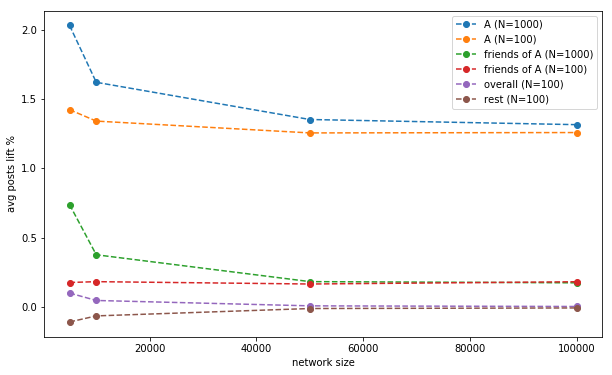

In [27]:
def lift(x): return (x/baseline_avg_posts - 1)*100
def xs(n): return take(filter(lambda x: x[0] == n, stats_list), 1)
def ys(n, i): return [lift(x) for x in take(take(filter(lambda x: x[0] == n, stats_list), 2), i)]
plt.figure(figsize=(10,6))
plt.xlabel('network size')
plt.ylabel('avg posts lift %')
plt.plot(xs(1000), ys(1000, 0), marker='o', linestyle='--')
plt.plot(xs(100), ys(100, 0),   marker='o', linestyle='--')
plt.plot(xs(1000), ys(1000, 1), marker='o', linestyle='--')
plt.plot(xs(100), ys(100, 1),   marker='o', linestyle='--')
plt.plot(xs(100), ys(100, 3),   marker='o', linestyle='--')
plt.plot(xs(100), ys(100, 2),   marker='o', linestyle='--')

plt.legend([
    'A (N=1000)',
    'A (N=100)',
    'friends of A (N=1000)',
    'friends of A (N=100)',
    'overall (N=100)',
    'rest (N=100)',
], loc='upper right')
plt.show()

In [2]:
# network_scaling_worker.py

from networkx.generators.random_graphs import connected_watts_strogatz_graph
from collections import defaultdict, Counter
from random import random, sample
import multiprocessing as mp
from itertools import cycle
import matplotlib as mpl
import networkx as nx
import numpy as np

def mp_degree_distribution(args):
    (n, k, p) = args
    g = connected_watts_strogatz_graph(n, k, p)
    ds = Counter(sorted([d for n, d in g.degree()], reverse=True))
    d, c = zip(*ds.items())
    return p, d, c

def mp_lifts(args):
    (n, k, p, N, T) = args
    g = connected_watts_strogatz_graph(n, k, p).to_directed()
    population_A = set(sample(g.nodes, N))
    stats = compute_stats(g, population_A, T)
    return (args, stats)

def mp_shortest_paths(args):
    (n, k, p, num_samples) = args
    g = connected_watts_strogatz_graph(n, k, p)
    samples = []
    for _ in range(num_samples):
        st = sample(g.nodes, 2)
        l = nx.shortest_path_length(g, st[0], st[1])
        samples.append(l)
    mean_shortest_path = np.mean(samples)
    return (args, mean_shortest_path)

def step_posts(g, yesterday_posts, population_A=set(), intrinsic=1/4, network_effect=3/200, effect_size = 0.00):
    today_posts = defaultdict(int)
    # baseline
    for v in g.nodes:
        if v in population_A:
            # experiment
            today_posts[v] = intrinsic * (1 + effect_size)
        else:
            today_posts[v] = intrinsic
    # network effect
    if yesterday_posts is not None:
        for (v1, v2) in g.edges:
            today_posts[v2] += yesterday_posts[v1] * network_effect
    return today_posts

def compute_stats(g, population_A, T):
    friends_of_A = set([])
    for (v1, v2) in g.edges:
        if v1 in population_A and v2 not in population_A:
            friends_of_A.add(v2)
    rest = set(g.nodes) - population_A
    rest = rest - friends_of_A
    posts = prev_posts = None
    for t in range(T):
        posts = step_posts(g, prev_posts, population_A=population_A, effect_size=0.05)
        prev_posts = posts
    avg_posts_all = np.mean(list(posts.values()))
    avg_posts_A = np.mean([v for (k, v) in posts.items() if k in population_A])
    avg_posts_A_friends = np.mean([v for (k, v) in posts.items() if k in friends_of_A])
    avg_posts_rest = np.mean([v for (k, v) in posts.items() if k in rest])
    return (avg_posts_A, avg_posts_A_friends, avg_posts_rest, avg_posts_all)